# Deep Earth PREM: The effect of ICB radius on the Earth's inertia coefficient (I/MR<sup>2</sup>)

In computing PREM, one of the constraints that Dziewonski and Anderson satisfied was the inertia coefficient of the Earth, given as $I/MR^2=0.3308$ (without errors).  Here we can test the effect on the inertia coefficient of changing the ICB radius.

To do the calculations, we need to import a few things.

In [1]:
using SeisModels
using Plots: plot, plot!, hline!, vline!

These two above give us access to the seismic models module, `SeisModels` (see the [documentation](https://anowacki.github.io/SeisModels.jl/stable/) for more information) and [Plots](http://docs.juliaplots.org/latest/) to make figures.

In [2]:
using Measurements
using Measurements: value, uncertainty
using Unitful: kg, km, m

These packages allow us to deal with errors and units easily.

## Earth reference values and uncertainties

The current reference values for the Earth have changed a small amount from those used in making PREM.  The following are taken from Chambat & Valette (PEPI, 2001):

In [3]:
M = (5.9733 ± 0.0090).*1e24*kg # Earth's mass
R = (6_370_994.4 ± 3.0)*m # Earth's reference radius
I = (8.018 ± 0.012).*1e13*m^2*kg # Moment of interia
I_MR² = 0.330714 ± 0.000008 # Inertia coefficient

0.330714 ± 8.0e-6

### Comparing inertia coefficient as the ICB radius changes

First of all, let's define a function to compute the inertia coefficient for a `SeisModel`.  (Note that in Julia, the last evaluated expression is returned, so this does indeed return $I/MR^2$.)

In [4]:
"Compute the inertia coefficient, I/MR², for a `SeisModel`."
function inertia_coefficient(m::SeisModel)
    R = surface_radius(m) # km
    I = moment_of_inertia(m) # kg⋅m²
    M = mass(m, R) # kg
    I/(M*(1e3*R)^2) # Convert radius to m
end

inertia_coefficient

Now, we can find out what the inertia coefficient is whilst changing the ICB radius 500 km either way from PREM's value.  This will have an effect because the density of the inner core is higher.

With `SeisModels`, the easiest way is to create a copy of the `PREM` inbuilt model and perturb the radius of the ICB in the copy and record the inertia coefficient.

In PREM, the inner core is the first layer of the model, so we can vary the radius of the first layer in our copy of PREM, prem$'$ by changing the value of `prem′.r[1]`. 

In [5]:
prem′ = deepcopy(PREM)
prem_r_icb = PREM.r[1]
r_icb = prem_r_icb .+ (-500:500)
icoeffs = zeros(length(r_icb))
for (i, r) in enumerate(r_icb)
    prem′.r[1] = r
    icoeffs[i] = inertia_coefficient(prem′)
end

(In Julia, you can usually type symbols in like you would in LaTeX math mode and pressing `<tab>`, so for `prem′` type `prem\prime` and then hit `<tab>`, or for ² type `\^2<tab>`; this works in Jupyter notebooks too.)

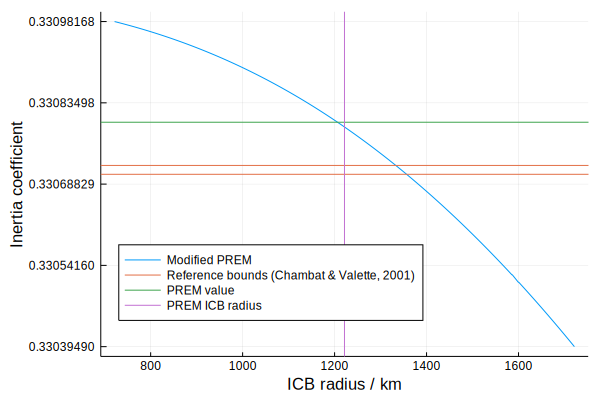

In [6]:
# Help GR with y-axis ticks
ticks = range(minimum(icoeffs), stop=maximum(icoeffs), length=5)
plot(r_icb, icoeffs, xlabel="ICB radius / km", ylabel="Inertia coefficient",
    legend=:bottomleft, yticks=ticks, label="Modified PREM")
hline!([value(I_MR²) - uncertainty(I_MR²), value(I_MR²) + uncertainty(I_MR²)],
    label="Reference bounds (Chambat & Valette, 2001)")
hline!([0.3308], label="PREM value")
vline!([prem_r_icb], label="PREM ICB radius")

What is the best fitting ICB radius to satisfy the modern $I/MR^2$ constraint?

In [7]:
icb_r_best = r_icb[argmin(abs.(value(I_MR²) .- icoeffs))]

1344.5

What does this model look like?  We haven't changed the polynomial coefficients representing the inner and outer core at all, only the radius over which they are evaluated.

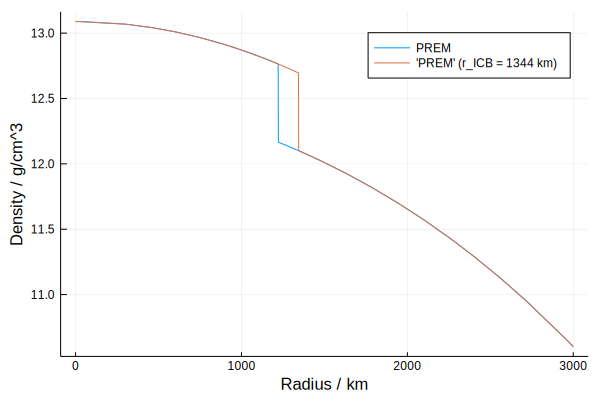

In [8]:
prem′.r[1] = icb_r_best # Model with 'best' ICB radius
plot(r -> density(PREM, r), 0, 3000, label="PREM",
    xlabel="Radius / km", ylabel="Density / g/cm^3")
plot!(r -> density(prem′, r), 0, 3000,
    label="'PREM' (r_ICB = $(round(Int, icb_r_best)) km)")

So, PREM satisfies its own constraints on the inertia coefficient, but more modern constraints on $I/MR^2$ would be a bit different.  If all you did was make PREM's inner core bigger by about 130 km, this would be fine... but then other things might start to go wrong...  For instance, the density and velocity jumps at the ICB would be different, and perhaps the total mass might go off too.

Let's check what happens to the total mass with our new ideal ICB radius:

In [9]:
mass_icb_best = mass(prem′, 0, depth=true)*kg

5.974548143153812e24 kg

In [10]:
value(M) - uncertainty(M) <= mass_icb_best <= value(M) + uncertainty(M)

true

So we can still satisfy the total mass.  But as for seismic travel times and normal mode frequencies?  That's another story...